In [1]:
"""
2023.03.16
    尝试以自己思路实现一个object detection模型，当然，免不了回头看一下代码
    暂定使用plt.imread读图片，h w c  RGB
"""
%matplotlib inline
import torch
import torchvision
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.nn import functional as F

torch.set_printoptions(2)

In [2]:
def multibox_prior(img, sizes, ratios):
    """
    为每个像素生成多个不同的anchors

    Args:
        img: 输入是[batch, c, h, w]
        sizes: list 不同大小
        ratios: list 不同比例
    return: 为每个像素生成的bbox_per_pixel个anchor坐标  [1, h * w * bbox_per_pixel, 4]
    """
    h, w = img.shape[-2:]
    num_sizes, num_ratios = len(sizes), len(ratios)
    sizes, ratios = torch.tensor(sizes), torch.tensor(ratios)
    bbox_per_pixel = num_sizes + num_ratios - 1
    # 生成anchors的中心点
    offset_h, offset_w = .5, .5     # 为使anchor中心与像素中心重合，前提是像素为1单位
    step_h, step_w = 1. / h, 1. / w
    center_h = (torch.arange(h) + offset_h) * step_h
    center_w = (torch.arange(w) + offset_w) * step_w
    shift_x, shift_y = torch.meshgrid((center_h, center_w), indexing='ij')
    shift_x, shift_y = shift_x.reshape(-1), shift_y.reshape(-1)
    anchor_center_points = torch.stack(tensors=(shift_x, shift_y, shift_x, shift_y), dim=1).repeat_interleave(bbox_per_pixel, dim=0)     # shift_x, shift_y, shift_x, shift_y这样取值是因为后面要生成topleft、bottomright坐标，分别用中心坐标生成
    # 生成anchors的宽高，即以每个像素为中心的anchors宽高各num_sizes + num_ratios - 1个
    shift_h = torch.cat(tensors=(sizes[0] / torch.sqrt(ratios), sizes[1:] / torch.sqrt(ratios[0]))) * h
    shift_w = torch.cat(tensors=(sizes[0] * torch.sqrt(ratios), sizes[1:] * torch.sqrt(ratios[0]))) * h
    # print(f'{shift_h}\n{shift_w}')
    # 获得半宽、半高
    anchor_wh_half = torch.stack(tensors=(-shift_w, -shift_h, shift_w, shift_h), dim=1).repeat(h * w, 1) / 2     # stack需要仔细理解一下
    # 返回anchors坐标，每个像素生成bbox_per_pixel个anchors
    anchors_coord = anchor_center_points + anchor_wh_half
    return anchors_coord.unsqueeze(0)

In [3]:
def show_bboxes(axes, bboxes, labels=None) -> None:
    """
    将bboxes画到axes上

    Args:
        axes: 需要外接传入fig.axes
        bboxes: 框的坐标，左上右下
        labels: 如果是预测框会有标记，不传则是简单画框而已
    """
    for i, bbox in enumerate(bboxes):
        rectangle = plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2] - bbox[0], height=bbox[3] - bbox[1], fill=False, linewidth=1)
        axes.add_patch(rectangle)
        if labels:
            if not isinstance(labels, (tuple, list)):
                labels = [labels]
            axes.text(x=bbox[0], y=bbox[1], s=labels[i])

In [4]:
def box_iou(boxes1, boxes2):
    """
    【实现细节较多】计算框之间的iou，特点是能处理批量数据。boxes1中所有框分别和boxes2中所有框比较
    比如boxes1有n个框，boxes2有m个框，结果会有n*m个iou值
    Args:
        boxes1: [batch/boxes1的框数量, 4]
        boxes2: [batch/boxes2的框数量, 4]
    """
    get_area = lambda box: (box[:, 2] - box[:, 0]) * (box[:, 3] - box[:, 1])
    areas1 = get_area(boxes1)   # [boxes1数量, ]
    areas2 = get_area(boxes2)
    print(f'{boxes1.device}\n{boxes2.device}')
    upleft_coords = torch.max(boxes1[:, None, :2], boxes2[:, :2])   # [boxes1数量，boxes2数量，2]
    bottomright_coords = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = torch.clamp(bottomright_coords - upleft_coords, min=0)     # [boxes1数量，boxes2数量，2]
    inter_areas = inters[:, :, 0] * inters[:, :, 1]     # [boxes1数量，boxes2数量]
    union_areas = areas1.unsqueeze(1) + areas2 - inter_areas    # areas1.unsqueeze(1)与areas1[:, None]均可升维
    return inter_areas / union_areas

In [39]:
def assign_bboxes_to_anchors(gts, ans, iou_threshold=.5):
    """
    anchors的类别和偏移量根据其最接近的ground truth决定，可理解为给anchors分配ground truth

    Args:
        gts: [gts数量, 4]
        ans: [ans数量, 4]
        iou_threshold: Defaults to .5.
    return: ans_gts_map映射矩阵 [ans数量,]
    """
    # 初始化一些变量
    # num_gts, num_ans = gts.shape[0], ans.shape[0]
    # row_discard = torch.full(num_gts, -1)
    # col_discard = torch.full(num_ans, -1)
    # 填充ans_gts_map索引映射矩阵
    ans_gts_map = torch.full(size=(ans.shape[0], ), fill_value=-1, device=gts.device)      # ans与gts的映射关系，以索引表示
    ious = box_iou(ans, gts)    # [ans数量, gts数量]  类比那个iou矩阵
    maxiou, inds = torch.max(ious, dim=1)   # 沿dim=1计算，这里是沿 行，即每一行最大的数及其索引
    ans_inds = torch.nonzero(maxiou >= iou_threshold).reshape(-1)   # 能分配到gts的ans索引
    gts_inds = inds[maxiou >= iou_threshold]    # 分配出去的gts索引
    ans_gts_map[ans_inds] = gts_inds
    # 我觉得后面代码没必要了，上面ans_gts_map已经通过iou_threshold映射好了，后面不必再重新计算用0填充ious的行列了
    # for _ in range(num_gts):
    #     i = torch.argmax(ious)
    #     row = int(i / ious.shape[1])    # i所在ious矩阵的行列索引
    #     col = int(i % ious.shape[1])
    #     ans_gts_map[row] = col
    #     ious[row, :] = row_discard
    #     ious[:, col] = col_discard
    return ans_gts_map

In [6]:
def box_corner_to_center(boxes):
    """
    左上右下坐标：坐标可能超出图片范围-->中心坐标：中心坐标肯定在图片范围之内
    x1,y1,x2,y2-->x,y,w,h

    Args:
        boxes: 暂认为[boxes数量, 4]

    Returns:
    """
    w, h = boxes[:, 2] - boxes[:, 0], boxes[:, 3] - boxes[:, 1]
    x_c, y_c = boxes[:, 0] + w / 2, boxes[:, 1] + h / 2
    return torch.stack((x_c, y_c, w, h), dim=1)

In [7]:
def multibox_target(ans, gts):
    """
    用gts标记ans的类别和偏移量

    Args:
        ans: [batch, ans数量, 4]
        gts: [batch, gts数量, 5] ground truth没有置信度，所以是5
    Returns: 1个batch所有样本ans的 bbox_offset(中心坐标), bbox_mask, class_lables 
    """
    batch_size = gts.shape[0]
    ans = ans.squeeze(0)    # 去掉batch维度，我的理解：batch里面有多个样本，每个样本生成相同的ans，所以这里直接把ans的batch维度抹掉了
    num_ans = ans.shape[0]
    batch_offset, batch_mask, batch_class_labels = [], [], []
    for i in range(batch_size):     # 逐个样本处理
        gt = gts[i, :, :]   # 拿1个样本的gts。1个样本可以有多个gts
        # print(f'*****************{gt.shape}, {ans.shape}')
        ans_gts_map = assign_bboxes_to_anchors(gt[:, 1:], ans)     # [ans数量,]
        ans_mask = (ans_gts_map >= 0).float().unsqueeze(-1).repeat(1, 4)   # [ans数量,]->[ans数量,1]->[ans数量,4]
        ans_labels = torch.zeros(num_ans)
        assigned_gts = torch.zeros((num_ans, 4))
        
        map_true = torch.nonzero(ans_gts_map >= 0)

        assigned_bb_ids = ans_gts_map[map_true]
        # print(f'*********************** {gt} {assigned_bb_ids}')      # gt误写为了gts
        ans_labels[map_true] = gt[assigned_bb_ids, 0] + 1  # 这里要记得类别数 + 1
        assigned_gts[map_true] = gt[assigned_bb_ids, 1:]
        # 计算偏移量
        assigned_gts_center = box_corner_to_center(assigned_gts)
        ans_center = box_corner_to_center(ans)
        offset = torch.cat((assigned_gts_center[:, :2] - ans_center[:, :2], assigned_gts_center[:, 2:] - ans_center[:, 2:]), dim=1) 
        # 准备返回结果
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(ans_mask.reshape(-1))
        batch_class_labels.append(ans_labels.long())
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_lables = torch.stack(batch_class_labels)
    return bbox_offset, bbox_mask, class_lables


In [8]:
def box_center_to_corner(ans):
    """
    Args:
        ans: [ans数量，4]

    Returns:
        _description_
    """
    w, h = ans[:, 2], ans[:, 3]
    x1, y1 = ans[:, 0] - w / 2, ans[:, 1] - h / 2
    x2, y2 = ans[:, 0] + w / 2, ans[:, 1] + h / 2
    return torch.stack(tensors=(x1, y1, x2, y2), dim=1)

In [9]:
def offset_inverse(ans, offset):
    """
    ans+offset=preds

    Args:
        ans: [ans数量, 4] 左上右下坐标
        offset: [ans数量, 4] 中心坐标
    Retures: preds [ans数量, 4] 左上右下坐标
    """
    ans = box_corner_to_center(ans)
    preds = ans + offset
    preds = box_center_to_corner(preds)
    return preds

In [10]:
def nms(preds, scores, iou_threshold=.5):
    """
    非极大值抑制

    Args:
        preds: [ans数量, 4]
        scores: [ans数量, ]
        iou_threshold: Defaults to .5.
    Retures: preds中保留预测框的索引
    """
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []   # 保留的ans索引
    while B.numel():
        keep.append(B[0])
        if B.numel() == 1:
            break
        ious = box_iou(preds[B[0], :].reshape(-1, 4), preds[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(ious <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep)

In [11]:
#@save
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框"""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # 找到所有的non_keep索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # pos_threshold是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

In [12]:
img = plt.imread('images/catdog.jpg')
h, w = img.shape[:2]
print(h, w)

561 728


In [13]:
def display_anchors(fmap_w, fmap_h, s):
    """
    在长宽为fmap_h、fmap_w的特征图上以像素为中心生成anchors，并画到特征图上

    Args:
        fmap_w: width of feature map
        fmap_h: height of feature map
        s: sizes列表
    """
    fmap = torch.zeros(size=(1, 10, fmap_h, fmap_w))    # 注意 B C H W顺序
    anchors = multibox_prior(fmap, s, [1, 2, .5])
    bbox_scale = torch.tensor((w, h, w, h))
    show_bboxes(plt.imshow(img).axes, anchors[0] * bbox_scale)
    plt.show()

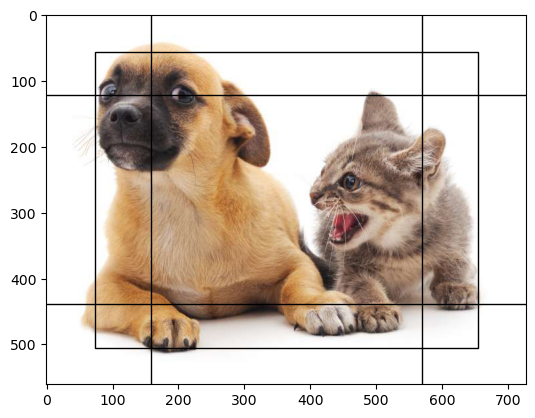

In [14]:
display_anchors(1, 1, s=[.8])

In [15]:
def read_data_bananas(is_train=True):
    data_dir = r'../data/banana-detection/'
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        img = plt.imread(os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'images', img_name))
        target = list(target)
        images.append(torch.from_numpy(img).permute(2, 0, 1))
        targets.append(target)
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [16]:
class BnanasDataset(torch.utils.data.Dataset):
    def __init__(self, is_train) -> None:
        self.features, self.lalbes = read_data_bananas(is_train)
        print(f'read {len(self.features)} {"training" if is_train else "valing"} examples')
    
    def __getitem__(self, ind):
        return self.features[ind].float(), self.lalbes[ind]
    
    def __len__(self):
        return len(self.features)

In [17]:
def load_data_bananas(batch_size):
    train_iter = torch.utils.data.DataLoader(BnanasDataset(True), batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BnanasDataset(False), batch_size, shuffle=False)
    return train_iter, val_iter

In [18]:
batch_size = 32
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 valing examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

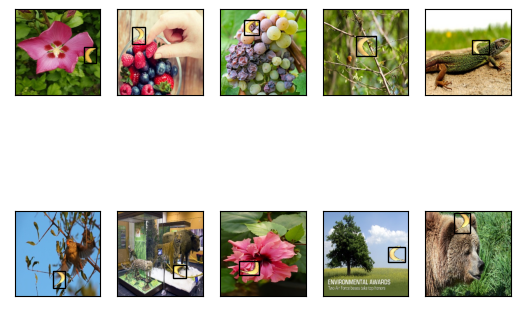

In [19]:
imgs = batch[0][:10].permute(0, 2, 3, 1)
labels = batch[1][:10]
fig, axes = plt.subplots(2, 5)
axes = axes.flatten()
for img, label, ax in zip(imgs, labels, axes):
    ax.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    show_bboxes(ax, [label[0][1:] * 256])

In [20]:
def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1), kernel_size=3, padding=1)

In [21]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

In [22]:
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [23]:
def flatten_pred(pred):
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_pred(preds):
    return torch.cat([flatten_pred(pred) for pred in preds], dim=1)

In [24]:
concat_pred([Y1, Y2]).shape

torch.Size([2, 25300])

In [25]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(kernel_size=2))
    return nn.Sequential(*blk)

In [26]:
forward(torch.zeros(size=(2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

In [27]:
def base_net():
    """ 基础块：3个宽高减半块 """
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i + 1]))
    return nn.Sequential(*blk)

In [28]:
forward(torch.zeros(size=(2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

In [29]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 2 or i == 3:
        blk = down_sample_blk(128, 128)
    else:
        blk = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    return blk

In [30]:
def blk_forward(X, blk, sizes, ratios, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = multibox_prior(Y, sizes, ratios)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return Y, anchors, cls_preds, bbox_preds

In [31]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [32]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs) -> None:
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i], num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i], num_anchors))
    
    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(X, 
                                                                    getattr(self, f'blk_{i}'), 
                                                                    sizes[i], ratios[i],
                                                                    getattr(self, f'cls_{i}'),
                                                                    getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        # print(f'$$$$$$$$$$$ {concat_pred(cls_preds).shape}')
        cls_preds = concat_pred(cls_preds)
        cls_preds = cls_preds.reshape(cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_pred(bbox_preds)
        return anchors, cls_preds, bbox_preds


In [33]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print(f'output anchors:{anchors.shape}\n'
      f'output cls preds:{cls_preds.shape}\n'
      f'output bbox preds:{bbox_preds.shape}')

output anchors:torch.Size([1, 5444, 4])
output cls preds:torch.Size([32, 5444, 2])
output bbox preds:torch.Size([32, 21776])


In [34]:
batch_size = 16
train_iter, _ = load_data_bananas(batch_size)

read 1000 training examples
read 100 valing examples


In [35]:
device = torch.device(f'cuda:0') if torch.cuda.device_count() else torch.device(f'cpu')
net = TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=.2, weight_decay=5e-4)

In [36]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes), cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

In [37]:
def cls_eval(cls_preds, cls_labels):
    return float((cls_preds.argmax(dim=-1).type(cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

$$$$$$$$ tensor([-1, -1, -1,  ..., -1, -1, -1], device='cuda:0')
cuda:0


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

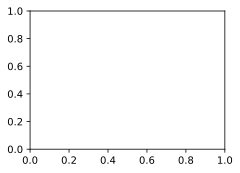

In [38]:
from d2l import torch as d2l
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        anchors, cls_preds, bbox_preds = net(X)
        bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, Y)
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')